In [1]:
import os
import numpy as np
import tensorflow as tf
import data.data_selector as ds
import utils.rd_plot_functions as pf
import utils.data_processing as dp
import matplotlib.pyplot as plt
from data.dataset import Dataset
import imageio
%matplotlib inline

# No whitening

## Training data

### Overlapping

In [2]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 1000000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": False,
  "contrast_normalize": False,
  "standardize_data": True,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [ ]:
data = ds.get_data(params)

In [10]:
np.savez(params["out_dir"] + 'train_nowht.npz', data)

## Testing data

### Tiled

In [25]:
params = {
  "data_type": "vanHateren",
  "num_images": 1,
  "extract_patches": True,
  "num_patches": 1024,
  "patch_edge_size": 16,
  "overlapping_patches": False,
  "randomize_patches": False,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": False,
  "contrast_normalize": False,
  "standardize_data": True,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [26]:
data = ds.get_data(params)

In [27]:
patch_data_dim = (params['num_patches'], params['patch_edge_size'], params['patch_edge_size'])
img = dp.patches_to_image(np.reshape(data['train'].images, patch_data_dim), num_im=1, im_edge_size=512)

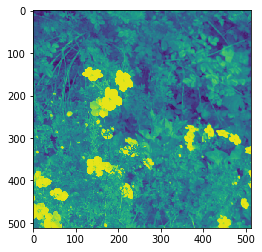

In [30]:
plt.imshow(img)

In [31]:
np.savez(params["out_dir"] + 'test_nowht_tiled_3.npz', data)

# Baboon, PCA whitened

In [2]:
params = {
  "num_images": 1,
  "extract_patches": True,
  "num_patches": 1024,
  "patch_edge_size": 16,
  "overlapping_patches": False,
  "randomize_patches": False,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "ZCA",
  "contrast_normalize": False,
  "standardize_data": True,
  "data_dir": "/media/tbell/sanborn/rd_analysis/inputs/baboon_gray.png",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [3]:
img = np.array(imageio.imread(params["data_dir"]), dtype='float64')
img = np.reshape(img, (1, 512, 512))

# img = np.reshape(dp.standardize_data(img), (1, 512, 512))
# if params["whiten_data"] == True:
#     img = dp.whiten_data(img, params["whiten_method"])  
img = Dataset(img, lbls=None, ignore_lbls=None, vectorize=True)
img.preprocess(params)
img.num_images = params["num_images"]
data = {'train': img}    
# img = dp.extract_tiled_patches(img, (1024, 256))
# img = np.reshape(img, (1024, 256))

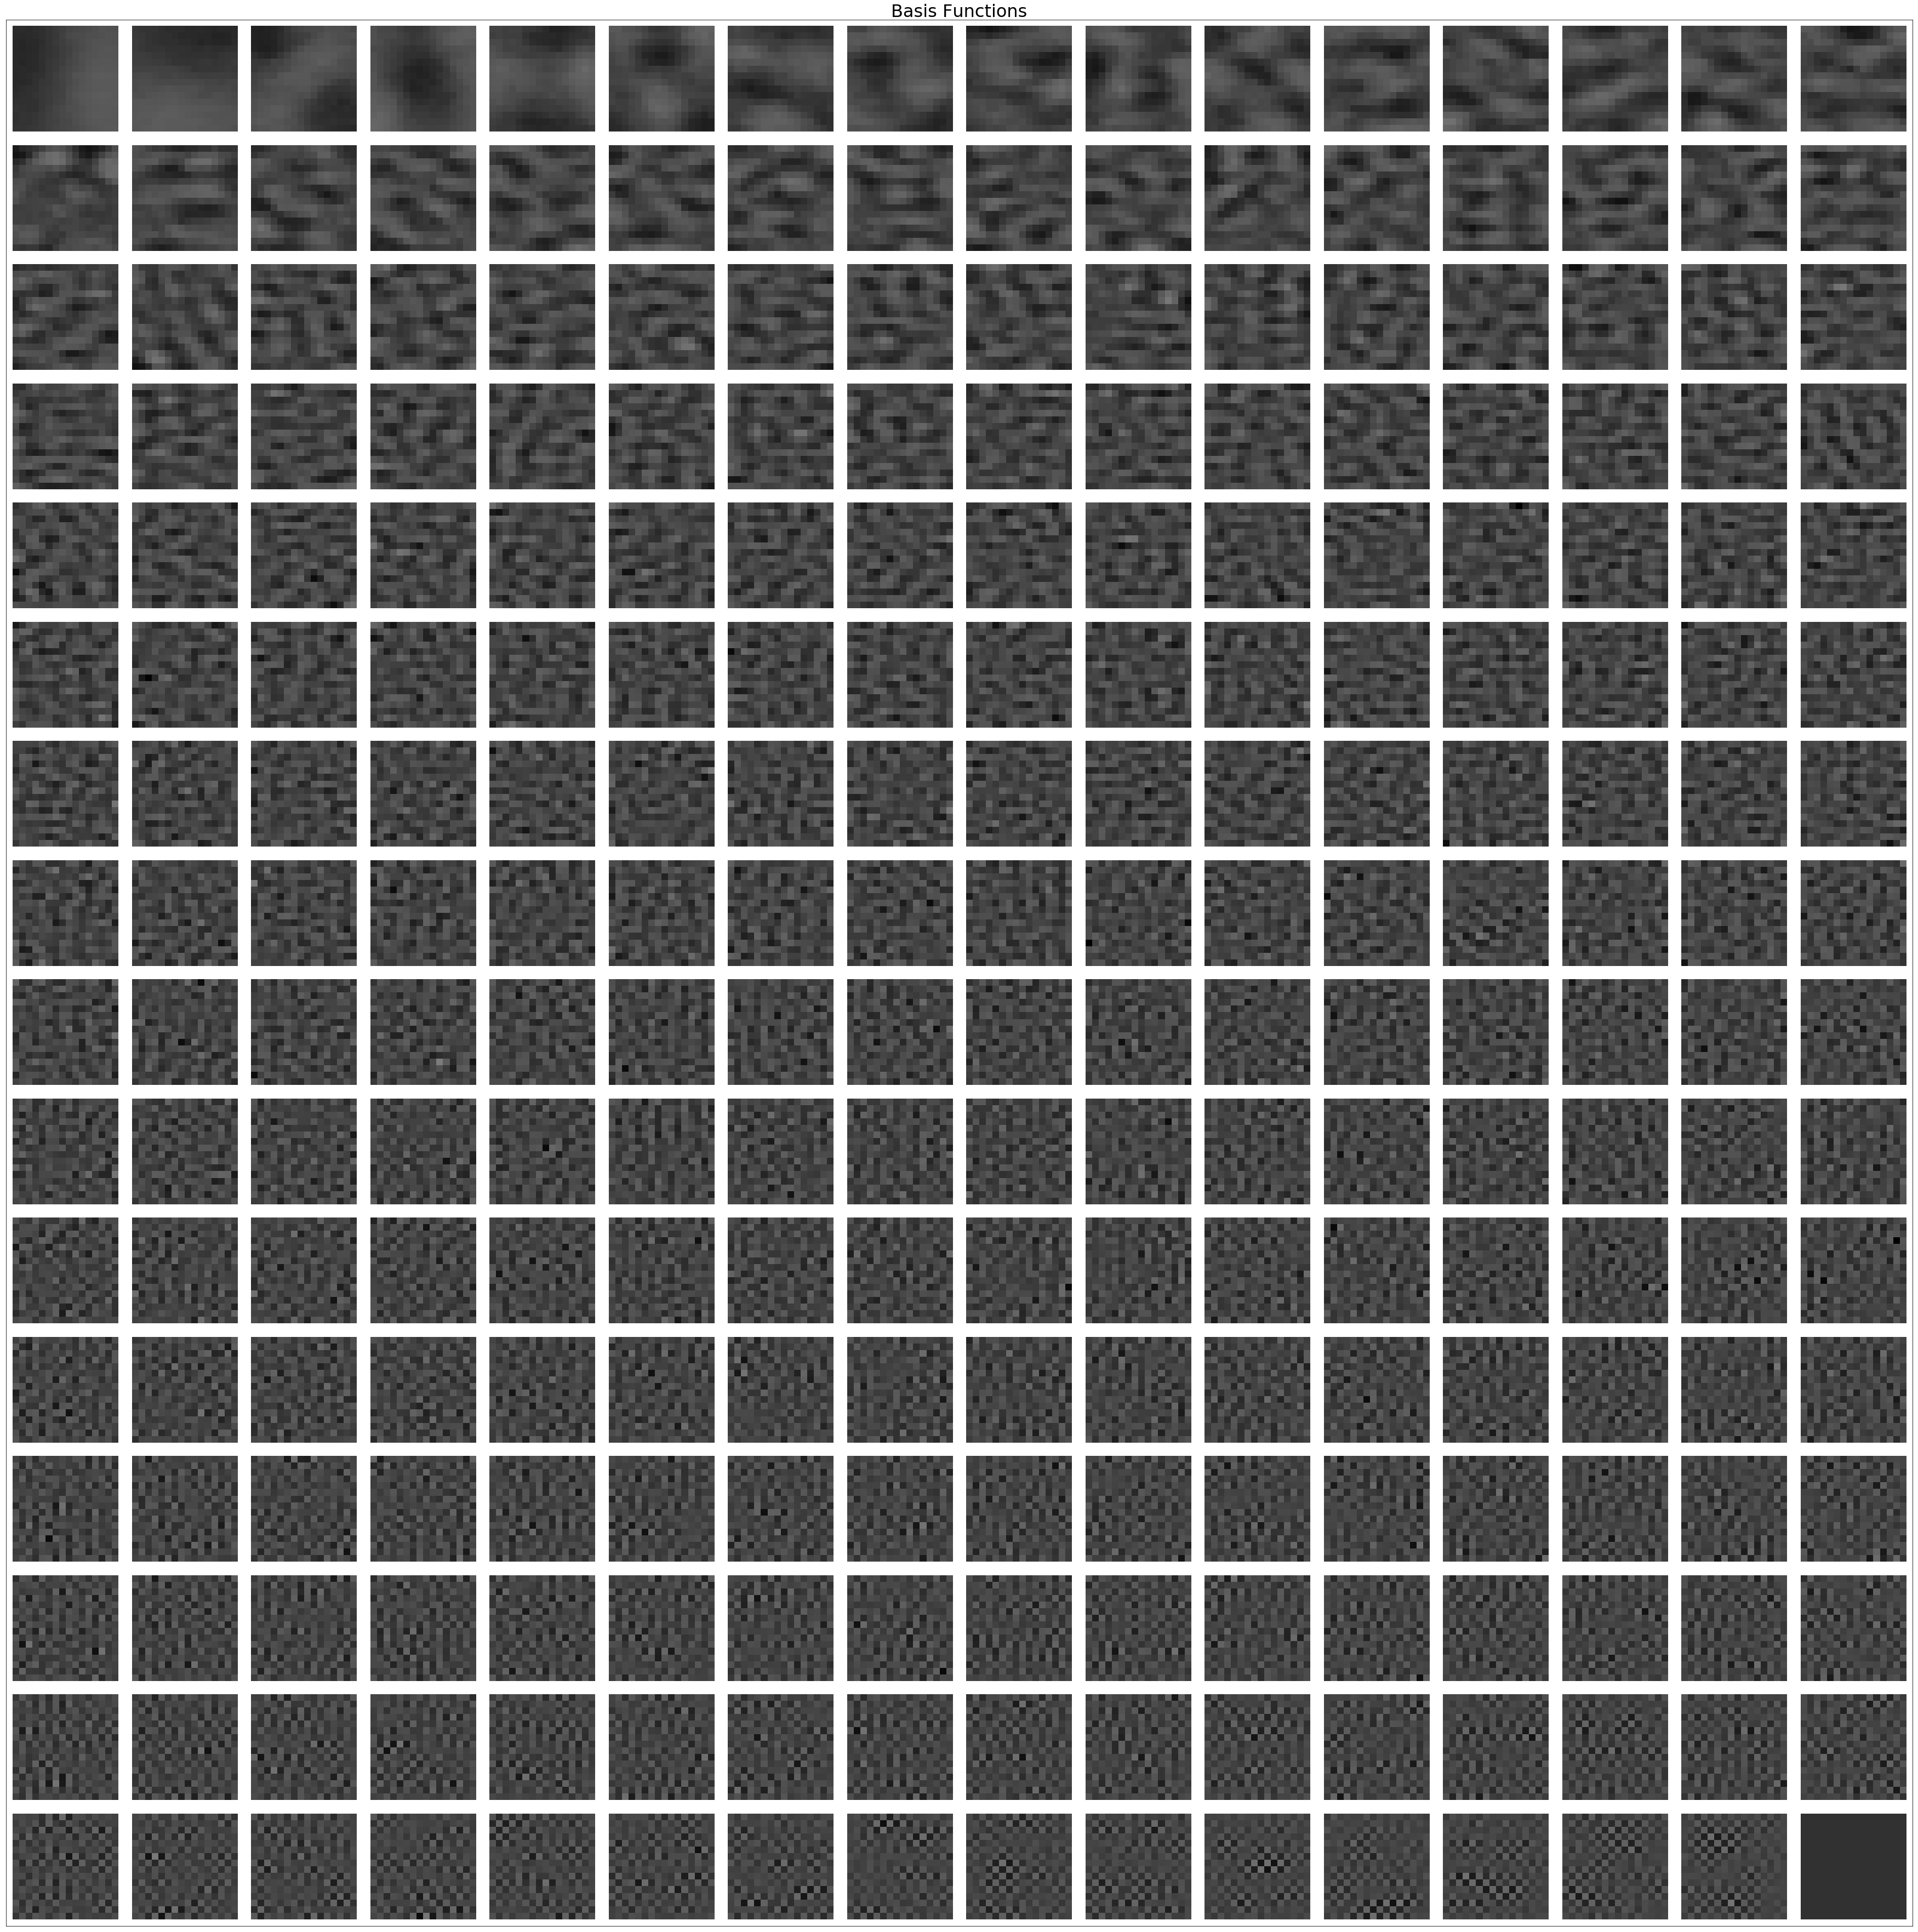

In [6]:
pf.plot_bases(data["train"].pca_matrix)

In [6]:
patch_data_dim = (params['num_patches'], params['patch_edge_size'], params['patch_edge_size'])
recon = dp.patches_to_image(np.reshape(data["train"].images, patch_data_dim), params['num_images'], 512)

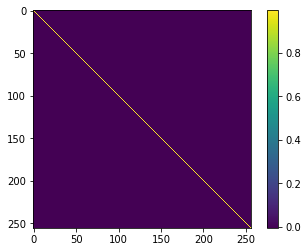

In [124]:
plt.imshow(np.divide(np.dot(data['train'].images.T, data['train'].images), data['train'].images.shape[0]))
plt.colorbar()

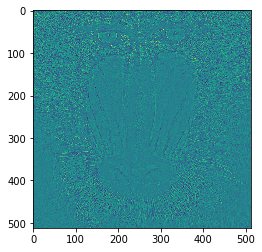

In [78]:
plt.imshow(recon)

In [7]:
np.savez('/media/tbell/sanborn/rd_analysis/inputs/baboon_zca_wht.npz', data)

## Overlapping

In [4]:
params = {
  "data_type": "vanHateren",
  "num_images": 1,
  "extract_patches": True,
  "num_patches": 100000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": False,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": False,
  "contrast_normalize": False,
  "standardize_data": True,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [5]:
data = ds.get_data(params)

In [6]:
np.savez(params["out_dir"] + 'test_100000.npz', data)

# Training data, overlapping, PCA whitened

In [8]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 1000000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "PCA",
  "contrast_normalize": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [9]:
data = ds.get_data(params)

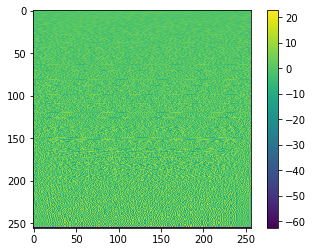

In [6]:
plt.imshow(data['train'].w_filter)
plt.colorbar()

In [7]:
np.savez(params["out_dir"] + 'train_pca_wht.npz', data)

# Training data, overlapping, ZCA whitened


In [7]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 1000000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "ZCA",
  "contrast_normalize": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [8]:
data = ds.get_data(params)

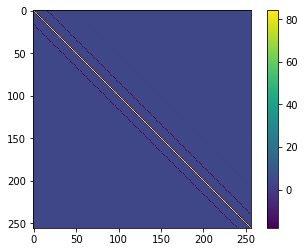

In [9]:
plt.imshow(data['train'].w_filter)
plt.colorbar()

In [10]:
np.savez(params["out_dir"] + 'train_zca_wht.npz', data)

# Training data, overlapping, FT whitened

In [4]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 1000000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "FT",
  "contrast_normalize": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [5]:
data = ds.get_data(params)

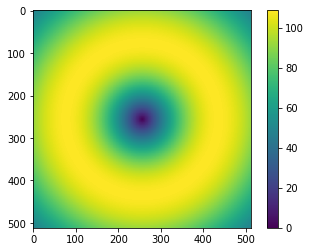

In [6]:
plt.imshow(data['train'].w_filter)
plt.colorbar()

In [7]:
np.savez(params["out_dir"] + 'train_ft_wht.npz', data)

# Testing data, overlapping, PCA whitened

In [11]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 100000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "PCA",
  "contrast_normalize": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [12]:
data = ds.get_data(params)

In [13]:
np.savez(params["out_dir"] + 'test_pca_wht.npz', data)

# Testing data, overlapping, ZCA whitened

In [2]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 100000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "ZCA",
  "contrast_normalize": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [3]:
data = ds.get_data(params)

# Testing data, overlapping, FT whitened

In [17]:
params = {
  "data_type": "vanHateren",
  "num_images": 50,
  "extract_patches": True,
  "num_patches": 100000,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "randomize_patches": True,
  "patch_variance_threshold": 1e-6,
  "norm_images": False,
  "whiten_data": True,
  "whiten_method": "FT",
  "contrast_normalize": False,
  "data_dir": "/media/tbell/datasets",
  "out_dir": "/media/tbell/sanborn/rd_analysis/inputs/"}

In [18]:
data = ds.get_data(params)

In [19]:
np.savez(params["out_dir"] + 'test_ft_wht.npz', data)